In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Load Fashion-MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Resize and convert grayscale to 3 channels
def preprocess(image, label):
  image = tf.image.resize(image[..., tf.newaxis], (224,224))  # Resize images
  image = tf.image.grayscale_to_rgb(image)  # Convert to 3 channels
  image = tf.cast(image, tf.float32) / 255.0  # Convert to float32
  label = tf.one_hot(label, depth=10)  # Convert to one-hot
  return image, label   #Normalize

# Create tf.data Datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(1000).batch(32).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocess).batch(32).prefetch(1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# Load base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the model

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Add custom layers on top
model = models.Sequential([base_model,
                           layers.GlobalAveragePooling2D(),
                           layers.Dense(128, activation = 'relu'),
                           layers.Dropout(0.5),
                           layers.Dense(10, activation = 'softmax')])

In [6]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# Train only the head
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 210s 104ms/step - accuracy: 0.2737 - loss: 1.9104 - val_accuracy: 0.5913 - val_loss: 1.2628
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 197s 105ms/step - accuracy: 0.4549 - loss: 1.3971 - val_accuracy: 0.6562 - val_loss: 1.0833
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 105ms/step - accuracy: 0.4987 - loss: 1.2604 - val_accuracy: 0.6776 - val_loss: 0.9737
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 197s 105ms/step - accuracy: 0.5232 - loss: 1.1986 - val_accuracy: 0.6920 - val_loss: 0.9093
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 198s 105ms/step - accuracy: 0.5404 - loss: 1.1533 - val_accuracy: 0.6941 - val_loss: 0.8600


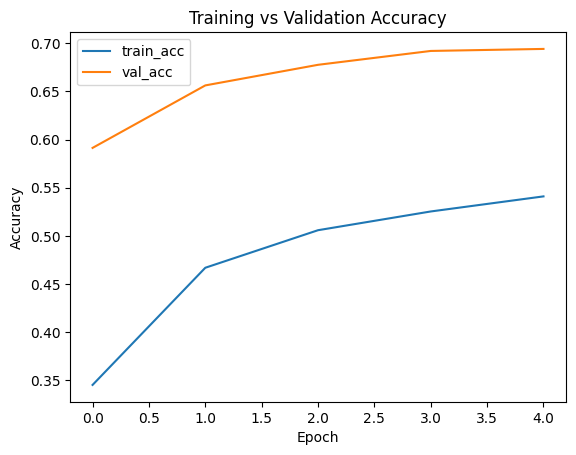

In [7]:
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

In [9]:
model.save("fashion_mnist_resnet50.keras")

Fine-Tuning the Model

In [7]:
# Unfreeze the last few layers of the base model
base_model.trainable = True

# Unfreeze only the last few blocks
for layer in base_model.layers[:-40]:
  #freeze all but last 40 layers
  layer.trainable = True

# Compile again with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Fine-tune the model
fine_tune_history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 652s 312ms/step - accuracy: 0.7035 - loss: 0.8865 - val_accuracy: 0.9028 - val_loss: 0.2784
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 584s 311ms/step - accuracy: 0.9104 - loss: 0.2715 - val_accuracy: 0.9207 - val_loss: 0.2238
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 623s 312ms/step - accuracy: 0.9372 - loss: 0.1887 - val_accuracy: 0.9271 - val_loss: 0.2146
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 620s 311ms/step - accuracy: 0.9531 - loss: 0.1391 - val_accuracy: 0.9308 - val_loss: 0.2147
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 622s 311ms/step - accuracy: 0.9694 - loss: 0.0935 - val_accuracy: 0.9307 - val_loss: 0.2612


In [11]:
model.save("fashion_mnist_resnet50.keras")

Data Augmentation

In [13]:
# Create augmented training pipeline
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                         layers.RandomRotation(0.1),
                                         layers.RandomZoom(0.1)])

# Adding augmentation inside preprocessing
def preprocess_with_aug(image, label):
  image = tf.image.resize(image[..., tf.newaxis], (224, 224))
  image = tf.image.grayscale_to_rgb(image)
  image = tf.cast(image, tf.float32) / 255.0
  image = data_augmentation(image)
  label = tf.one_hot(label, 10)
  return image, label

# Recreate training dataset with augmentation
aug_train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
aug_train_ds = aug_train_ds.map(preprocess_with_aug).shuffle(1000).batch(32).prefetch(1)

In [14]:
# Retraining with augmented data
history_aug = model.fit(aug_train_ds, epochs=3, validation_data=test_ds)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1224s 647ms/step - accuracy: 0.8839 - loss: 0.3619 - val_accuracy: 0.9311 - val_loss: 0.2025
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1288s 650ms/step - accuracy: 0.9215 - loss: 0.2349 - val_accuracy: 0.9350 - val_loss: 0.1969
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1207s 637ms/step - accuracy: 0.9303 - loss: 0.2083 - val_accuracy: 0.9354 - val_loss: 0.1941


In [15]:
model.save("fashion_mnist_resnet50.keras")

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - accuracy: 0.9375 - loss: 0.1874
Test accuracy: 0.94
313/313 ━━━━━━━━━━━━━━━━━━━━ 34s 94ms/step


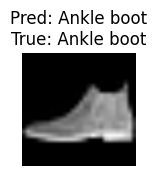

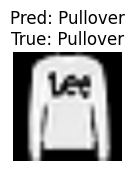

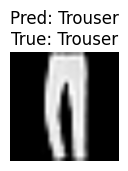

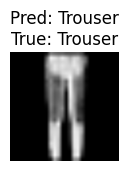

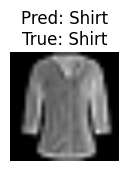

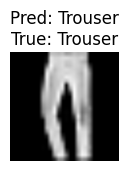

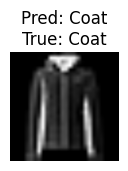

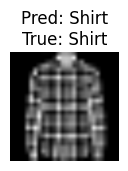

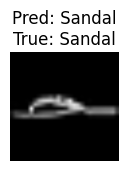

In [16]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.2}')

# Prediction on test samples
predictions = model.predict(test_ds)

# Show some predictions with images
import matplotlib.pyplot as plt

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Get actual images and labels
for images, labels in test_ds.take(1):
  pred_labels = tf.argmax(predictions[:9], axis=1)
  true_labels = tf.argmax(labels[:9], axis=1)
  plt.figure(figsize=(10,5))
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("float32"))
    plt.title(f"Pred: {class_names[pred_labels[i]]}\nTrue: {class_names[true_labels[i]]}")
    plt.axis("off")
    plt.show()

In [17]:
model.save("fashion_mnist_resnet50.keras")